# Deep-Dream Pytorch implementation

## Setup instructions
* Install Conda
https://www.anaconda.com/download/#macos

* Install pytorch and torchvision (computer vision for pytorch) package

`conda install pytorch torchvision -c pytorch`

https://pytorch.org/

## Overview
* https://ai.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html 
* https://en.wikipedia.org/wiki/DeepDream

## References
* https://github.com/sar-gupta/deep-dream-pytorch

### Python imports
* torch, numpy, torchvision
* PIL: Python Imaging Library
* pyplot: plotting image

In [1]:
import torch
from torchvision import models, transforms
import torch.optim as optim
import numpy as np
from matplotlib import pyplot
%matplotlib inline
from PIL import Image, ImageFilter, ImageChops

Program configs

In [2]:
CUDA_ENABLED = True

# Deep dream configs
LAYER_ID = 28 # The layer to maximize the activations through
NUM_ITERATIONS = 5 # Number of iterations to update the input image with the layer's gradient
LR = 0.2

# We downscale the image recursively, apply the deep dream computation, scale up, and then blend with the original image 
# to achieve better result.
NUM_DOWNSCALES = 20
BLEND_ALPHA = 0.5

DeepDream class: use a vgg16 pretrained model

In [3]:
class DeepDream:
    def __init__(self, image):
        self.image = image
        self.model = models.vgg16(pretrained=True)
        if CUDA_ENABLED:
            self.model = self.model.cuda()
        self.modules = list(self.model.features.modules())
        
        # vgg16 use 224x224 images
        imgSize = 224
        self.transformMean = [0.485, 0.456, 0.406]
        self.transformStd = [0.229, 0.224, 0.225]
        self.transformNormalise = transforms.Normalize(
            mean=self.transformMean,
            std=self.transformStd
        )
        
        self.transformPreprocess = transforms.Compose([
            transforms.Resize((imgSize, imgSize)),
            transforms.ToTensor(),
            self.transformNormalise
        ])
        
        self.tensorMean = torch.Tensor(self.transformMean)
        if CUDA_ENABLED:
            self.tensorMean = self.tensorMean.cuda()

        self.tensorStd = torch.Tensor(self.transformStd)
        if CUDA_ENABLED:
            self.tensorStd = self.tensorStd.cuda()

    def toImage(self, input):
        return input * self.tensorStd + self.tensorMean

### Main deep dream algorithm
Input 
* an input image
* layerId
* number of iterations

Makes a forward pass until layerId, computes the gradient and updates the input image. This is repeated for the given number of iterations.

In [4]:
class DeepDream(DeepDream):
    def deepDream(self, image, layer, iterations, lr):
        transformed = self.transformPreprocess(image).unsqueeze(0) # 转换后的图片
        if CUDA_ENABLED:
            transformed = transformed.cuda()
        input = torch.autograd.Variable(transformed, requires_grad=True)
        self.model.zero_grad()
        optimizer = optim.Adam([input.requires_grad_()],lr=LR)
        for _ in range(iterations):
            optimizer.zero_grad()
            out = input
            for layerId in range(layer):
                out = self.modules[layerId + 1](out)
            loss = -out.norm() # 让负的变小, 正的变大
            loss.backward()
            optimizer.step()
            # input.data = input.data + lr * input.grad.data

        input = input.data.squeeze()
        input.transpose_(0,1)
        input.transpose_(1,2)
        input = self.toImage(input)
        if CUDA_ENABLED:
            input = input.cpu()
        input = np.clip(input, 0, 1)
        return Image.fromarray(np.uint8(input*255))

Recursively apply deepDream at different scales and blend the result images to make the final image looks better.

In [5]:
class DeepDream(DeepDream):
    def deepDreamRecursive(self, image, layer, iterations, lr, num_downscales):
        if num_downscales > 0:
            # scale down the image
            image_small = image.filter(ImageFilter.GaussianBlur(2)) # 高斯模糊
            small_size = (int(image.size[0]/2), int(image.size[1]/2))            
            if (small_size[0] == 0 or small_size[1] == 0):
                small_size = image.size
            image_small = image_small.resize(small_size, Image.ANTIALIAS)
            
            # run deepDreamRecursive on the scaled down image
            image_small = self.deepDreamRecursive(image_small, layer, iterations, lr, num_downscales-1)
            
            print('Num Downscales : {}'.format(num_downscales))
            print('====Small Image=====')
            pyplot.imshow(image_small)
            pyplot.show()
            
            # Scale up the result image to the original size
            image_large = image_small.resize(image.size, Image.ANTIALIAS)
            
            print('====Large Image=====')
            pyplot.imshow(image_large)
            pyplot.show()
            
            # Blend the two image
            image = ImageChops.blend(image, image_large, BLEND_ALPHA)
            
            print('====Blend Image=====')
            pyplot.imshow(image)
            pyplot.show()
        
        img_result = self.deepDream(image, layer, iterations, lr)
        print(img_result.size)
        img_result = img_result.resize(image.size)
        print(img_result.size)
        return img_result
    
    def deepDreamProcess(self):
        return self.deepDreamRecursive(self.image, LAYER_ID, NUM_ITERATIONS, LR, NUM_DOWNSCALES)

Now, load an image

Text(0.5, 1.0, 'Image loaded from face.jpg')

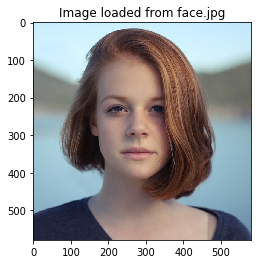

In [6]:
IMAGE_PATH = 'face.jpg'
img = Image.open(IMAGE_PATH)
  
pyplot.imshow(img)
pyplot.title("Image loaded from " + IMAGE_PATH)

Perform "deep dream" on it. Note that the computation could take a few minutes.

(224, 224)
(1, 1)
Num Downscales : 1
====Small Image=====


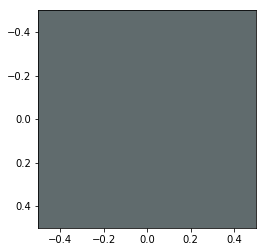

====Large Image=====


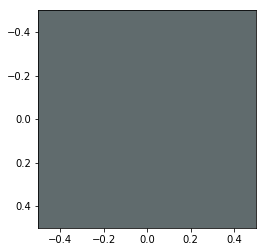

====Blend Image=====


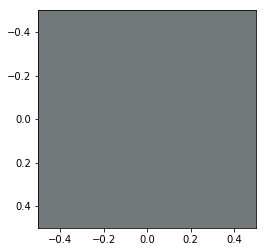

(224, 224)
(1, 1)
Num Downscales : 2
====Small Image=====


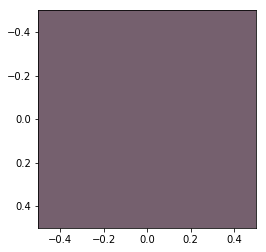

====Large Image=====


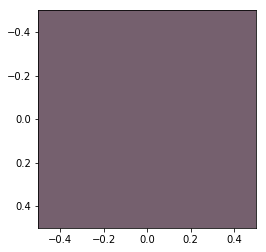

====Blend Image=====


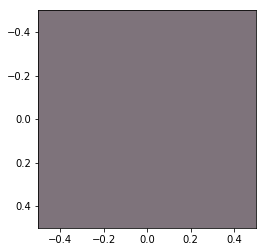

(224, 224)
(1, 1)
Num Downscales : 3
====Small Image=====


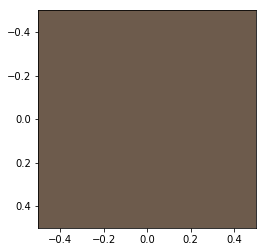

====Large Image=====


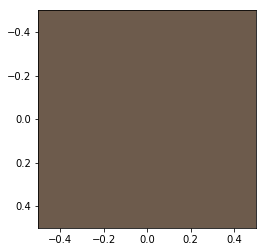

====Blend Image=====


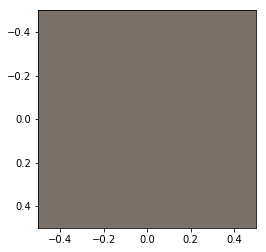

(224, 224)
(1, 1)
Num Downscales : 4
====Small Image=====


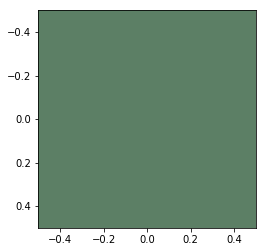

====Large Image=====


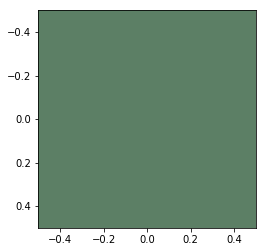

====Blend Image=====


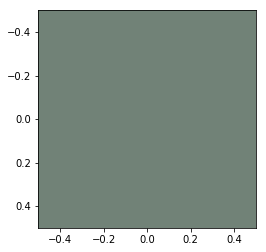

(224, 224)
(1, 1)
Num Downscales : 5
====Small Image=====


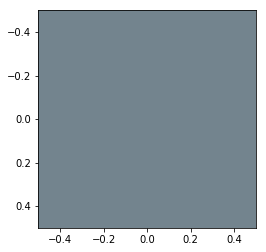

====Large Image=====


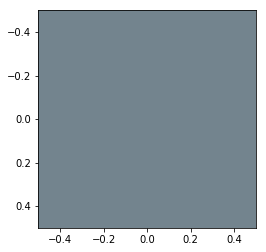

====Blend Image=====


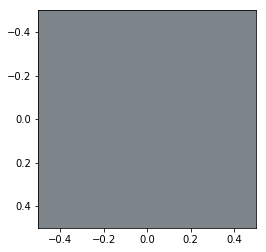

(224, 224)
(1, 1)
Num Downscales : 6
====Small Image=====


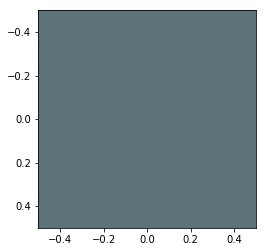

====Large Image=====


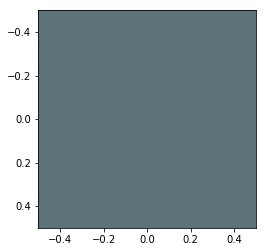

====Blend Image=====


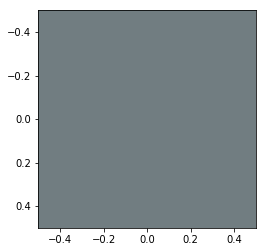

(224, 224)
(1, 1)
Num Downscales : 7
====Small Image=====


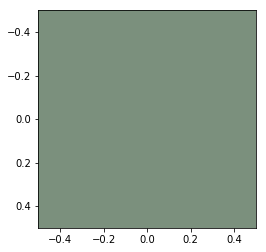

====Large Image=====


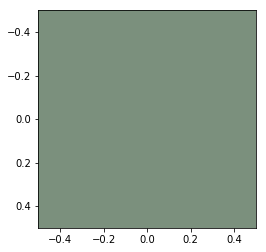

====Blend Image=====


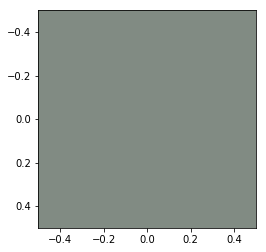

(224, 224)
(1, 1)
Num Downscales : 8
====Small Image=====


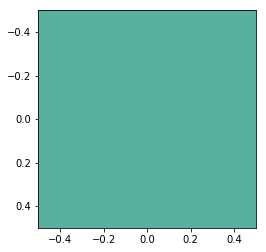

====Large Image=====


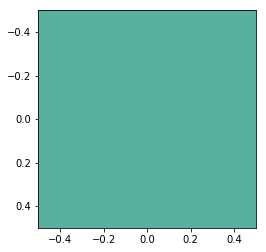

====Blend Image=====


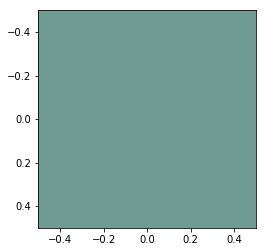

(224, 224)
(1, 1)
Num Downscales : 9
====Small Image=====


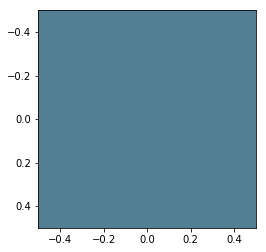

====Large Image=====


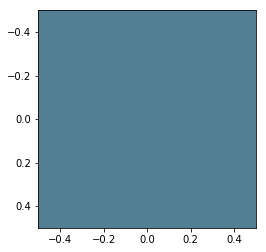

====Blend Image=====


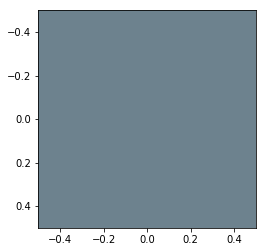

(224, 224)
(1, 1)
Num Downscales : 10
====Small Image=====


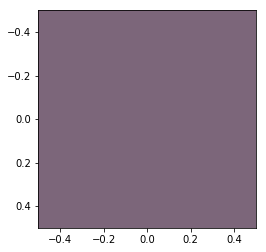

====Large Image=====


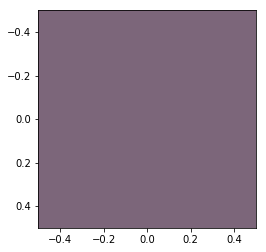

====Blend Image=====


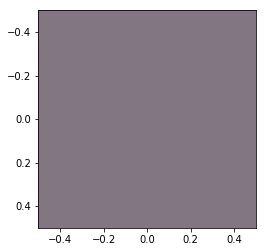

(224, 224)
(1, 1)
Num Downscales : 11
====Small Image=====


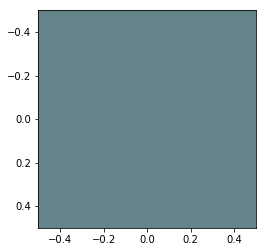

====Large Image=====


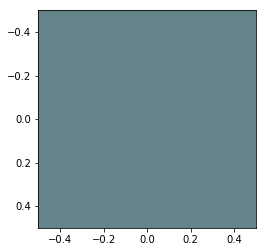

====Blend Image=====


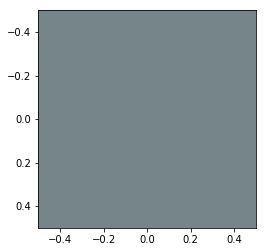

(224, 224)
(1, 1)
Num Downscales : 12
====Small Image=====


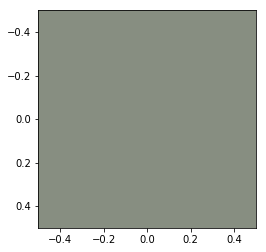

====Large Image=====


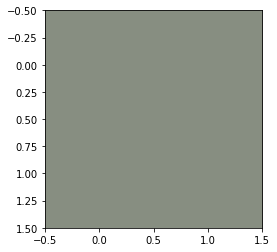

====Blend Image=====


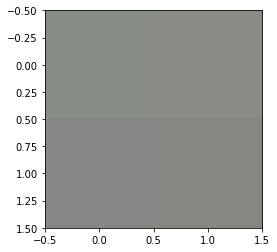

(224, 224)
(2, 2)
Num Downscales : 13
====Small Image=====


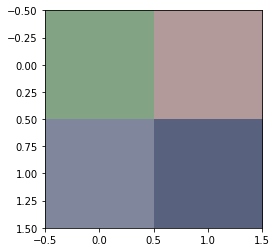

====Large Image=====


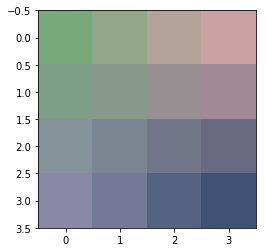

====Blend Image=====


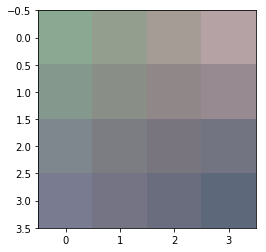

(224, 224)
(4, 4)
Num Downscales : 14
====Small Image=====


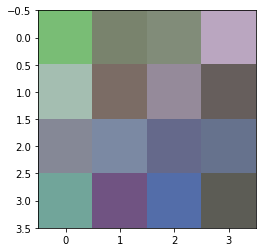

====Large Image=====


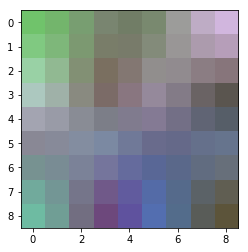

====Blend Image=====


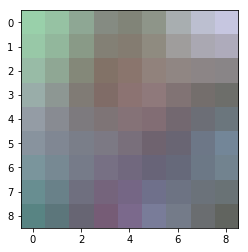

(224, 224)
(9, 9)
Num Downscales : 15
====Small Image=====


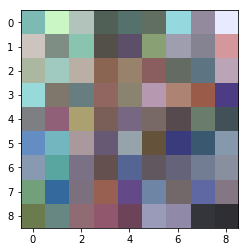

====Large Image=====


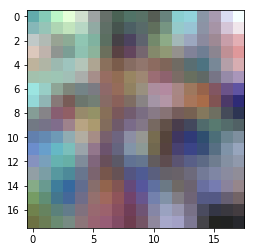

====Blend Image=====


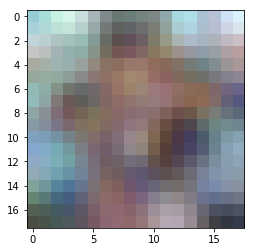

(224, 224)
(18, 18)
Num Downscales : 16
====Small Image=====


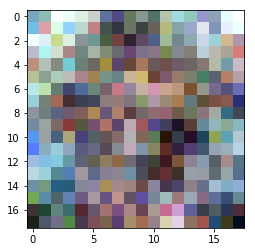

====Large Image=====


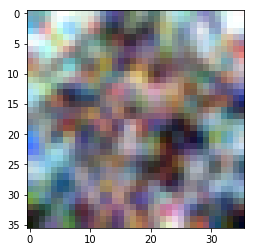

====Blend Image=====


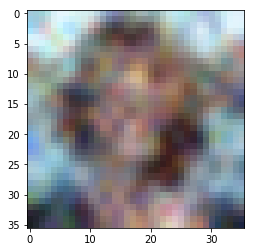

(224, 224)
(36, 36)
Num Downscales : 17
====Small Image=====


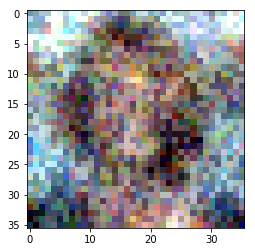

====Large Image=====


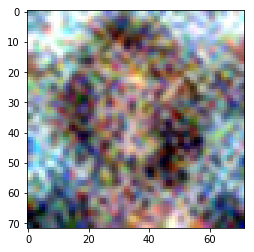

====Blend Image=====


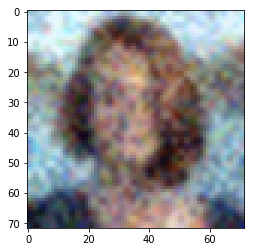

(224, 224)
(72, 72)
Num Downscales : 18
====Small Image=====


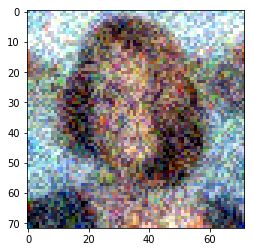

====Large Image=====


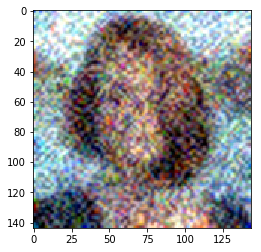

====Blend Image=====


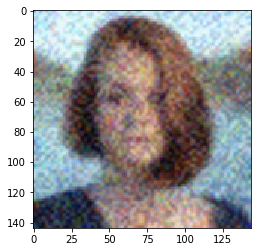

(224, 224)
(144, 144)
Num Downscales : 19
====Small Image=====


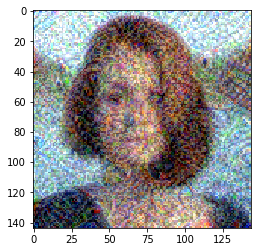

====Large Image=====


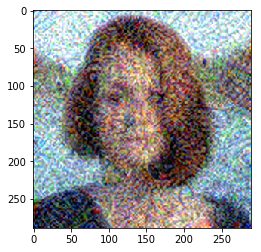

====Blend Image=====


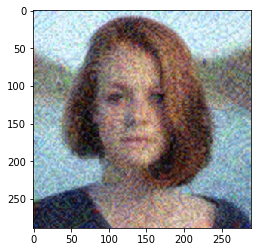

(224, 224)
(289, 289)
Num Downscales : 20
====Small Image=====


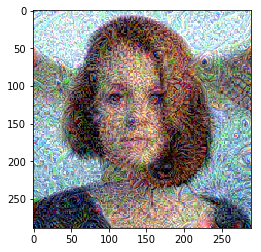

====Large Image=====


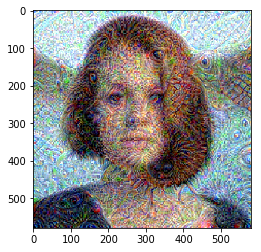

====Blend Image=====


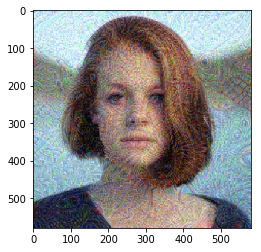

(224, 224)
(579, 579)


Text(0.5, 1.0, 'Deep dream image')

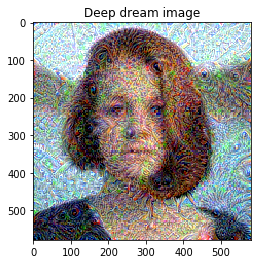

In [7]:
img_deep_dream = DeepDream(img).deepDreamProcess()
pyplot.imshow(img_deep_dream)
pyplot.title("Deep dream image")

In [8]:
img_deep_dream.save('deepdream_' + IMAGE_PATH)